In [ ]:
!pip install pandas matplotlib openpyxl

In [ ]:
#R1 : retourner les id des taggedComment dont le name du noeud tag qui le compose égale à "Tech"
#cozo query :
?[taggedId] :=
  *reified_node[taggedId],
  *n_composed_of_node[taggedId, tagNode],
  *node_label[tagNode, "tag"],
  *node_prop[tagNode, "name", "Tech"]


In [ ]:
#Cypher query (Neo4j) : 
MATCH (sg:taggedComment)-[:_node_membership]->(t:Tag {name: 'Tech'})
RETURN sg.id AS taggedCommentId;

In [ ]:
#HOGDB function query

# find_tagged_subgraphs_simple.py
from typing import List, Any

def _label_to_str(lbl: Any) -> str:
    """Retourne le nom de label en minuscules (tolérant aux différents types d'objets Label)."""
    if lbl is None:
        return ""
    for attr in ("value", "name", "label"):
        if hasattr(lbl, attr):
            try:
                return str(getattr(lbl, attr)).lower()
            except Exception:
                pass
    return str(lbl).lower()

def find_taggedcomment_subgraph_ids(subgraphs: List[Any], *,
                                    subgraph_label: str = "taggedComment",
                                    tag_node_label: str = "tag",
                                    tag_name_val: str = "Tech") -> List[Any]:
    """
    Parcourt une liste de Subgraph et retourne la valeur de la propriété 'id'
    pour les subgraphs qui ont le label `subgraph_label` et contiennent un Node
    ayant label `tag_node_label` et property 'name' == tag_name_val.
    """
    result = []
    target_sg_label = subgraph_label.lower()
    target_node_label = tag_node_label.lower()
    for sg in subgraphs:
        # vérifier label du subgraph
        sg_labels = [ _label_to_str(l) for l in getattr(sg, "labels", []) or [] ]
        if target_sg_label not in sg_labels:
            continue
        # parcourir les noeuds du subgraph
        for node in getattr(sg, "subgraph_nodes", []) or []:
            node_labels = [ _label_to_str(l) for l in getattr(node, "labels", []) or [] ]
            if target_node_label in node_labels:
                # accéder à la propriété 'name' via Node.__getitem__
                name_val = None
                try:
                    name_val = node["name"]
                except Exception:
                    # fallback: inspect properties list if necessary
                    props = getattr(node, "properties", []) or []
                    for p in props:
                        if getattr(p, "key", None) == "name":
                            name_val = getattr(p, "value", None)
                            break
                if name_val == tag_name_val:
                    # récupérer id du subgraph via Subgraph.__getitem__('id')
                    try:
                        sg_id = sg["id"]
                    except Exception:
                        # fallback: inspect properties list
                        sg_id = None
                        for p in getattr(sg, "properties", []) or []:
                            if getattr(p, "key", None) == "id":
                                sg_id = getattr(p, "value", None)
                                break
                    result.append(sg_id)
                    break  # ce subgraph est validé, on passe au suivant
    return result

# --- main ---
if __name__ == "__main__":
  

    #récupérer via GraphwithSubgraphStorage 
    try:
        from HOGDB.db.neo4j import Neo4jDatabase
        from HOGDB.graph.graph_with_subgraph_storage import GraphwithSubgraphStorage

        db = Neo4jDatabase()
        gs_sub = GraphwithSubgraphStorage(db)
        subgs = getattr(gs_sub, "subgraphs", None)
           
        ids = find_taggedcomment_subgraph_ids(subgs, subgraph_label="taggedComment",
                                             tag_node_label="Tag", tag_name_val="Tech")
        print("Found taggedComment subgraph ids:", ids)

        gs_sub.close_connection()
    except Exception as exc:
        print("Could not auto-fetch subgraphs:", exc)
      


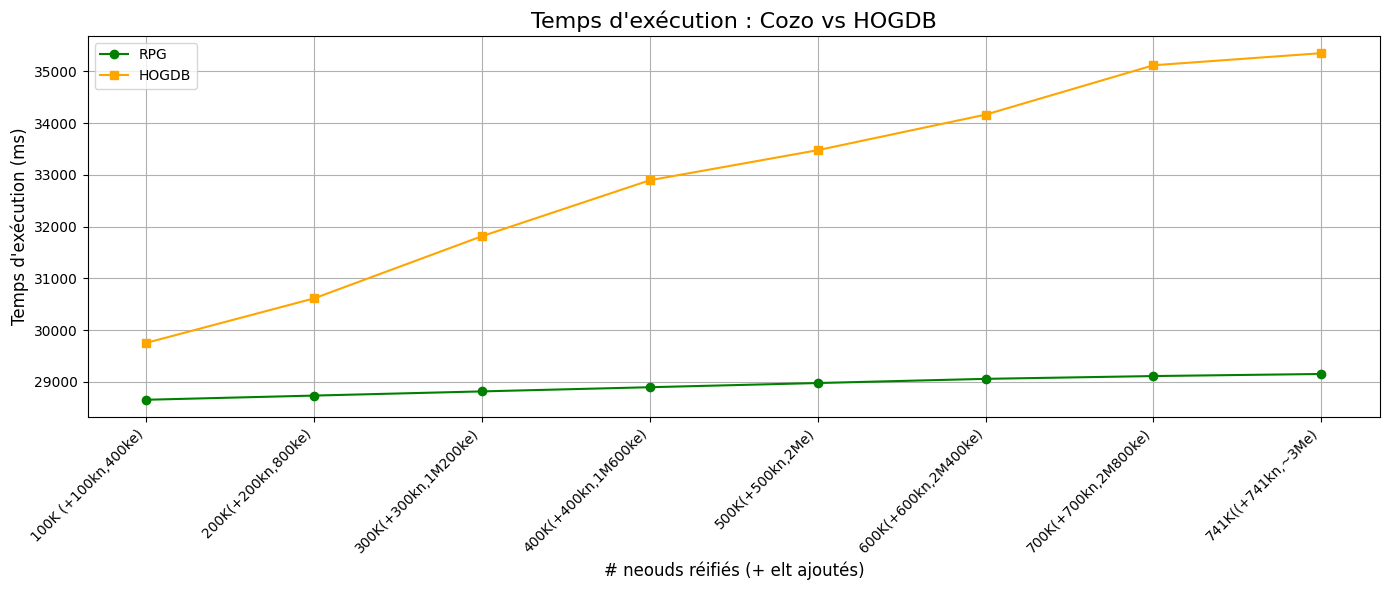

In [27]:
import pandas as pd
import matplotlib.pyplot as plt


file_path = "Cozo_vs_HOGDB.xlsx"

df = pd.read_excel(file_path)


plt.figure(figsize=(14, 6))
plt.plot(df['#reified nodes'], df['Cozo'], marker='o', color='green', label='RPG')
plt.plot(df['#reified nodes'], df['HOGDB'], marker='s', color='orange', label='HOGDB')

# Ajouter titre et axes
plt.title("Temps d'exécution : Cozo vs HOGDB", fontsize=16)
plt.xlabel("# neouds réifiés (+ elt ajoutés)", fontsize=12)
plt.ylabel("Temps d'exécution (ms)", fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.grid(True)
plt.tight_layout()

# Sauvegarder le graphique
plt.savefig("graph_cozo_vs_HOGDB.png")
plt.show()
